<a href="https://colab.research.google.com/github/Alino4kaAlino4ka/-Pyton4ik/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE_%D1%81%D0%BE%D1%82%D1%80%D1%83%D0%B4%D0%BD%D0%B8%D0%BA_Pyton4ik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai gradio tiktoken langchain langchain-openai langchain-community chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Импорт библиотек
import os
import gradio as gr
from google.colab import userdata
import tiktoken
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from openai import OpenAI
from langchain.embeddings import OpenAIEmbeddings

# Инициализация клиента VSEGPT
client = OpenAI(
    api_key=userdata.get('VSEGPT_API_KEY'),
    base_url="https://api.vsegpt.ru/v1"
)

In [ ]:
# Кастомные embeddings для работы с VSEGPT
class VSEGPTEmbeddings(OpenAIEmbeddings):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.client = client

    def embed_documents(self, texts):
        """Embed a list of texts using VSEGPT API"""
        responses = []
        for text in texts:
            response = self.client.embeddings.create(
                input=text,
                model="text-embedding-ada-002"
            )
            responses.append(response.data[0].embedding)
        return responses

    def embed_query(self, text):
        """Embed a single query using VSEGPT API"""
        response = self.client.embeddings.create(
            input=text,
            model="text-embedding-ada-002"
        )
        return response.data[0].embedding

# Проверка наличия ключа
if not client.api_key:
    raise ValueError("API ключ не найден в секретах Colab. Добавьте ключ в Secrets с именем VSEGPT_API_KEY")
else:
    print("API ключ успешно загружен!")



API ключ успешно загружен!


In [ ]:
class PythonAssistant:
    def __init__(self, model="openai/gpt-4o-mini"):
        self.log = ""
        self.model = model
        self.search_index = None
        self.embeddings = VSEGPTEmbeddings()
        self.system_prompt = """
        Ты - Python Guru, нейро-сотрудник для помощи программистам.
        Твоя целевая аудитория: начинающие и средние разработчики Python.

        Твои задачи:
        1. Объяснять концепции Python простым языком
        2. Давать примеры кода с пояснениями
        3. Помогать с отладкой и оптимизацией кода
        4. Отвечать на вопросы по фреймворкам и библиотекам Python

        Правила ответов:
        1. Будь точным и используй предоставленный контекст
        2. Для примеров кода используй markdown с подсветкой синтаксиса
        3. Если информации нет в контексте, скажи об этом
        4. Поддерживай дружелюбный профессиональный тон
        """

    def load_document(self, text):
        """Загрузка и обработка документа"""
        try:
            # Разбиваем текст на чанки
            splitter = CharacterTextSplitter(
                separator="\n",
                chunk_size=1000,
                chunk_overlap=200,
                length_function=self._num_tokens_from_string
            )

            chunks = splitter.split_text(text)
            documents = [Document(page_content=chunk) for chunk in chunks]

            # Создаем векторное хранилище
            self.search_index = Chroma.from_documents(
                documents,
                self.embeddings
            )

            self.log += f"Документ загружен. Чанков: {len(documents)}\n"
            return True

        except Exception as e:
            self.log += f"Ошибка загрузки документа: {str(e)}\n"
            return False

    def _num_tokens_from_string(self, string: str) -> int:
        """Подсчет токенов в строке"""
        encoding = tiktoken.encoding_for_model("gpt-4")
        return len(encoding.encode(string))

    def answer_question(self, user_question):
        """Ответ на вопрос с учетом контекста"""
        if not self.search_index:
            return "Ошибка: документ не загружен. Сначала загрузите базу знаний."

        try:
            # Поиск релевантных фрагментов
            docs = self.search_index.similarity_search(user_question, k=5)
            context = "\n\n".join([f"Контекст {i+1}:\n{doc.page_content}" for i, doc in enumerate(docs)])

            # Формируем промпт
            full_prompt = f"""
            {self.system_prompt}

            Контекст для ответа:
            {context}

            Вопрос: {user_question}

            Ответь максимально конкретно, используя предоставленный контекст.
            Если ответа нет в контексте, скажи об этом.
            Для примеров кода используй markdown с подсветкой синтаксиса.
            """

            # Отправляем запрос к VSEGPT API
            response = client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": self.system_prompt},
                    {"role": "user", "content": full_prompt}
                ],
                temperature=0.3
            )

            answer = response.choices[0].message.content

            # Логируем
            self.log += f"Вопрос: {user_question}\n"
            self.log += f"Использовано контекстов: {len(docs)}\n"
            self.log += f"Ответ: {answer[:200]}...\n"

            return answer

        except Exception as e:
            return f"Ошибка при генерации ответа: {str(e)}"


In [ ]:
# @title Подготовка базы знаний
# Структурированная база знаний по Python
python_knowledge_base = """
### Основы Python
#### Переменные и типы данных
Python использует динамическую типизацию. Основные типы:
- int: целые числа (10, -5)
- float: числа с плавающей точкой (3.14, -0.001)
- str: строки ("hello", 'world')
- bool: логические значения (True, False)
- list: упорядоченные изменяемые коллекции ([1, 2, 3])
- tuple: упорядоченные неизменяемые коллекции ((1, 2, 3))
- dict: словари {ключ: значение} ({"name": "Alice", "age": 25})
- set: уникальные неупорядоченные коллекции ({1, 2, 3})

Пример работы с переменными:
```python
x = 10  # int
name = "Alice"  # str
is_active = True  # bool
scores = [90, 85, 88]  # list
Условные операторы
Позволяют управлять потоком выполнения программы.

Основные операторы:

if: основное условие

elif: дополнительные условия

else: выполняется, если другие условия не сработали

Пример:

python
age = 18
if age < 13:
    print("Ребенок")
elif age < 18:
    print("Подросток")
else:
    print("Взрослый")
Функции
Определение функций
Функции объявляются с помощью def и могут возвращать значения через return.

Пример:

python
def calculate_area(width, height):
    '''Вычисляет площадь прямоугольника'''
    return width * height
Lambda-функции
Анонимные функции для простых операций.

Пример:

python
square = lambda x: x**2
sorted_names = sorted(names, key=lambda x: x.lower())
Работа с файлами
Чтение и запись
Для работы с файлами используется функция open().

Режимы:

'r' - чтение (по умолчанию)

'w' - запись (перезаписывает файл)

'a' - добавление в конец файла

'b' - бинарный режим

Пример:

python
# Чтение файла
with open('data.txt', 'r') as file:
    content = file.read()

# Запись в файл
with open('output.txt', 'w') as file:
    file.write("Hello, World!")
ООП в Python
Классы и объекты
Классы - это шаблоны для создания объектов.

Основные концепции:

init: конструктор класса

self: ссылка на экземпляр класса

Методы: функции, определенные внутри класса

Атрибуты: переменные, принадлежащие объекту

Пример:

python
class Dog:
    def __init__(self, name, breed):
        self.name = name
        self.breed = breed

    def bark(self):
        print(f"{self.name} says: Woof!")

# Создание объекта
my_dog = Dog("Rex", "Labrador")
my_dog.bark()
Наследование
Позволяет создавать новые классы на основе существующих.

Пример:

python
class Animal:
    def __init__(self, name):
        self.name = name

    def speak(self):
        raise NotImplementedError("Subclass must implement")

class Cat(Animal):
    def speak(self):
        print(f"{self.name} says: Meow!")
Популярные библиотеки
Requests
Для выполнения HTTP-запросов.

Пример GET-запроса:

python
import requests
response = requests.get('https://api.example.com/data')
if response.status_code == 200:
    data = response.json()
Pandas
Для работы с табличными данными.

Пример:

python
import pandas as pd
data = pd.read_csv('data.csv')
mean_score = data['score'].mean()
NumPy
Для научных вычислений.

Пример:

python
import numpy as np
arr = np.array([1, 2, 3])
squares = arr**2
"""

In [ ]:
assistant = PythonAssistant()

In [ ]:
# Загружаем базу знаний
assistant.load_document(python_knowledge_base)
print("База знаний загружена!")

База знаний загружена!


In [ ]:
# Функция для Gradio интерфейса
def ask_assistant(question):
    response = assistant.answer_question(question)
    return response

# Создание интерфейса
with gr.Blocks(title="Python4ik - Нейро-сотрудник") as demo:
    gr.Markdown("""
    # 🐍 Python4ik - Ваш нейро-помощник
    ### Задавайте вопросы по Python и получайте экспертные ответы!
    """)

    # Убираем gr.Row() и используем простую вертикальную компоновку
    question = gr.Textbox(label="Ваш вопрос", placeholder="Например: Как создать lambda-функцию?")
    output = gr.Textbox(label="Ответ", interactive=False)

    btn = gr.Button("Отправить")
    btn.click(fn=ask_assistant, inputs=question, outputs=output)

    gr.Markdown("""
    ## Оптимизации:
    1. **Структура базы знаний**: Двухуровневая организация (темы и подтемы)
    2. **Кастомные эмбеддинги**: Адаптированы для работы с VSEGPT API
    3. **Логирование**: Запись всех вопросов и ответов
    4. **Промпт-инжиниринг**: Четкие инструкции для нейро-сотрудника
    5. **Интерфейс Gradio**: Удобный веб-интерфейс для взаимодействия
    6. **Оптимальные параметры**: Температура 0.3 для баланса креативности/точности
    7. **Обработка ошибок**: Грамотное сообщение об ошибках пользователю
    """)

# Запуск интерфейса
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a53dcb5ce0842bbaee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


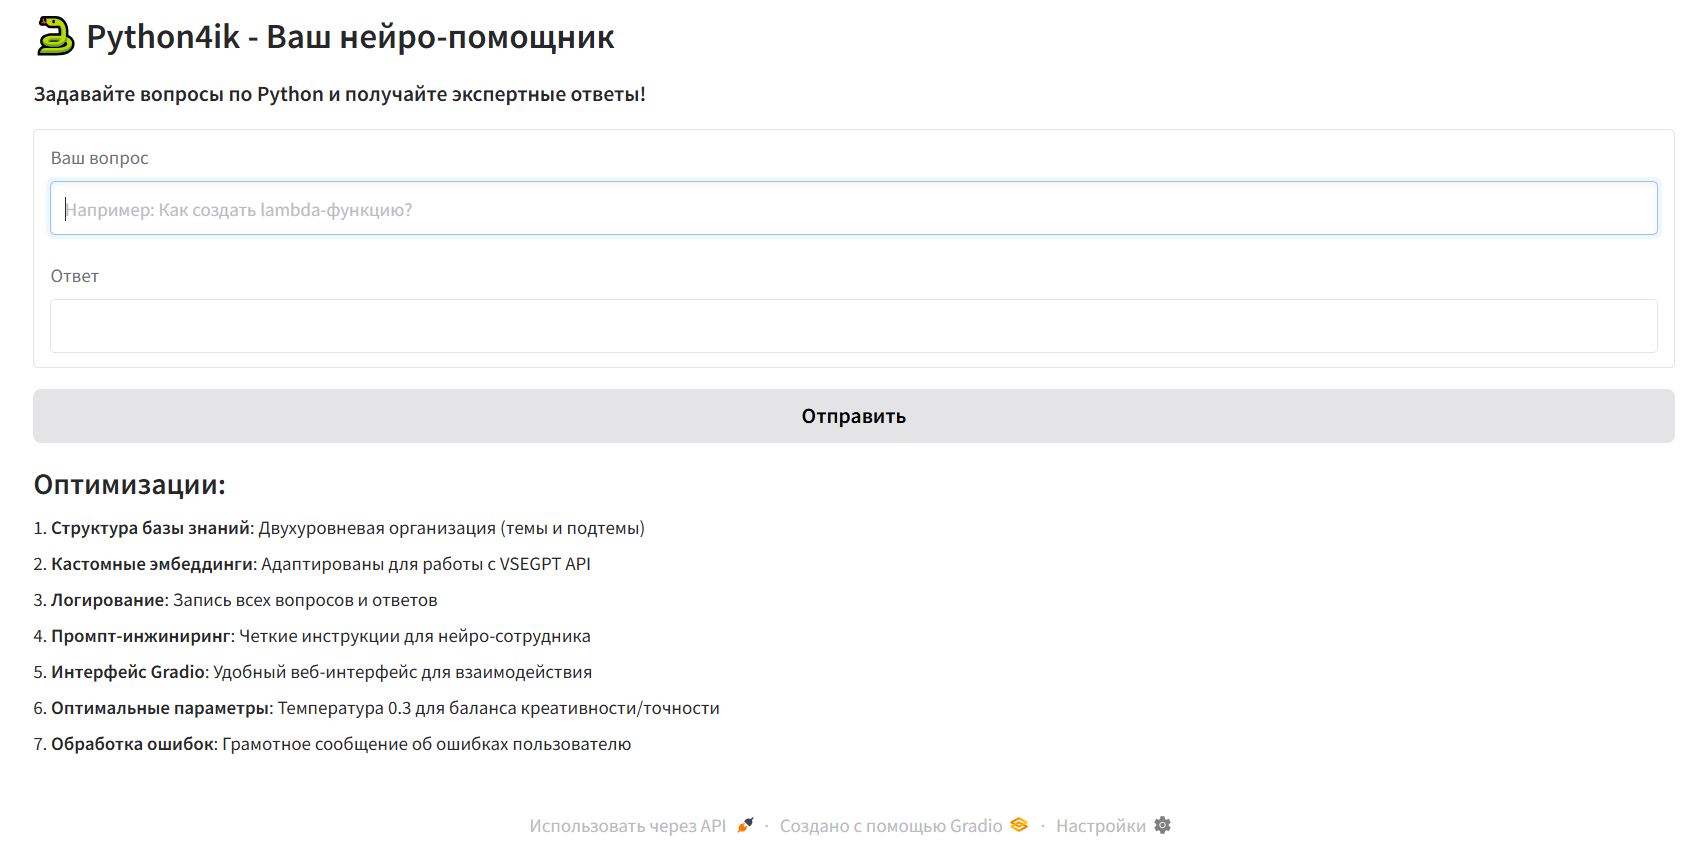

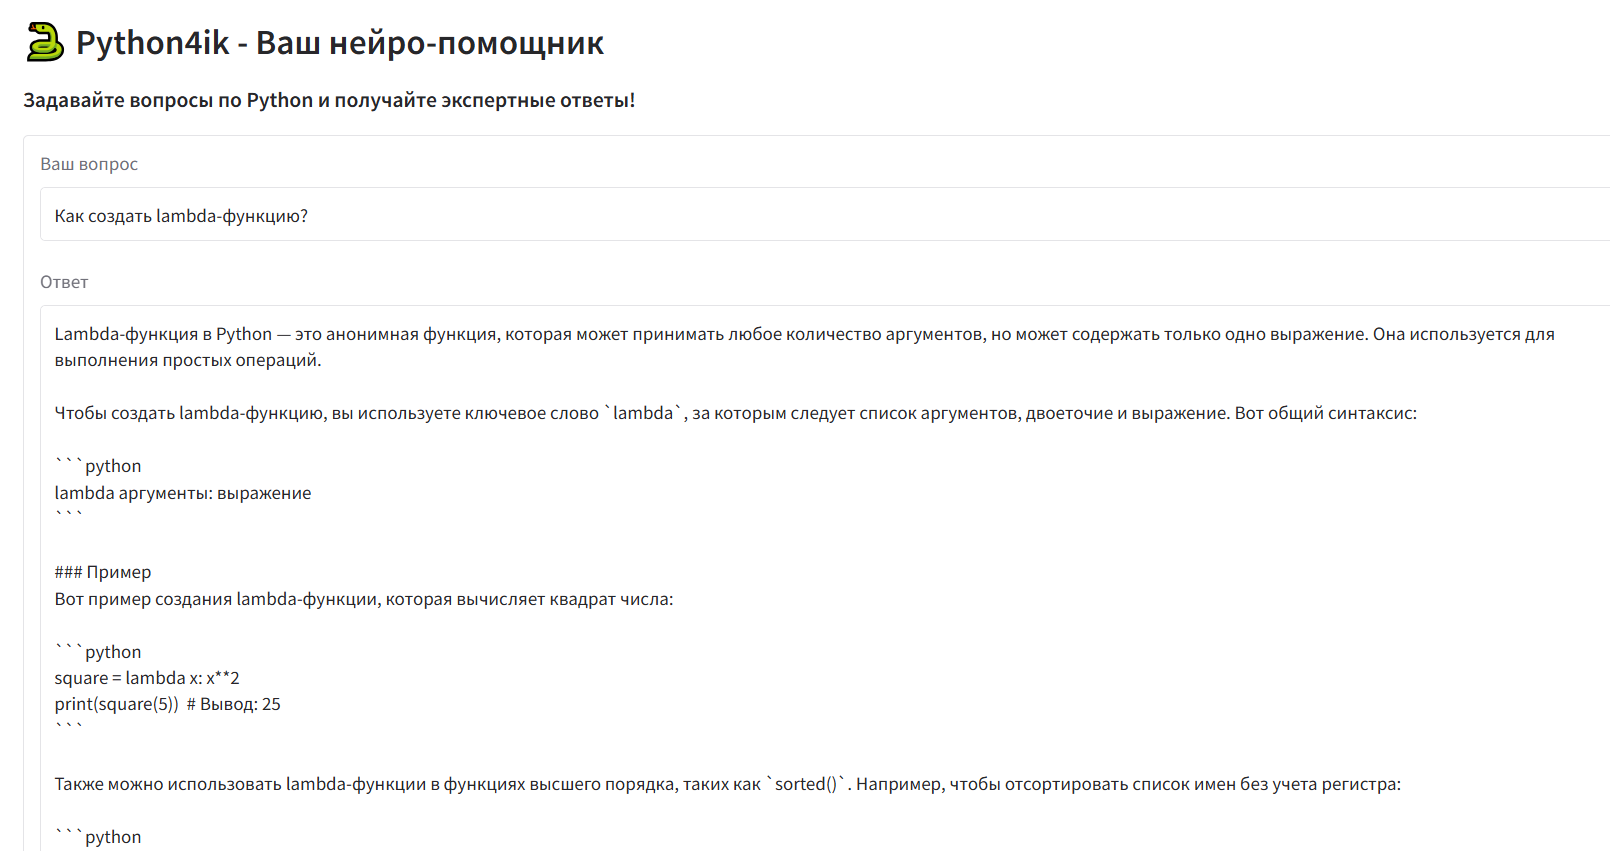

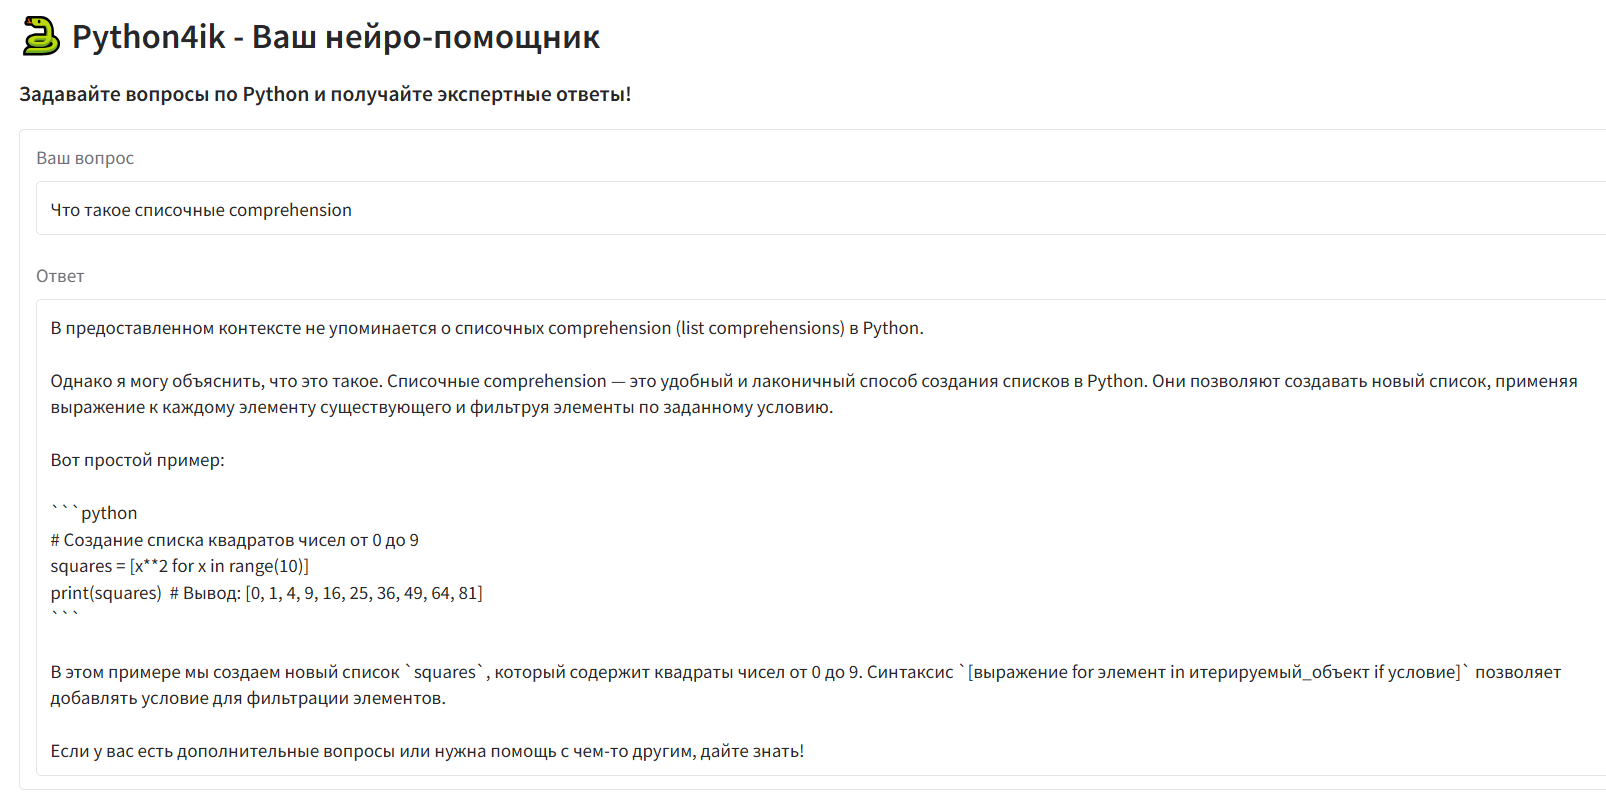

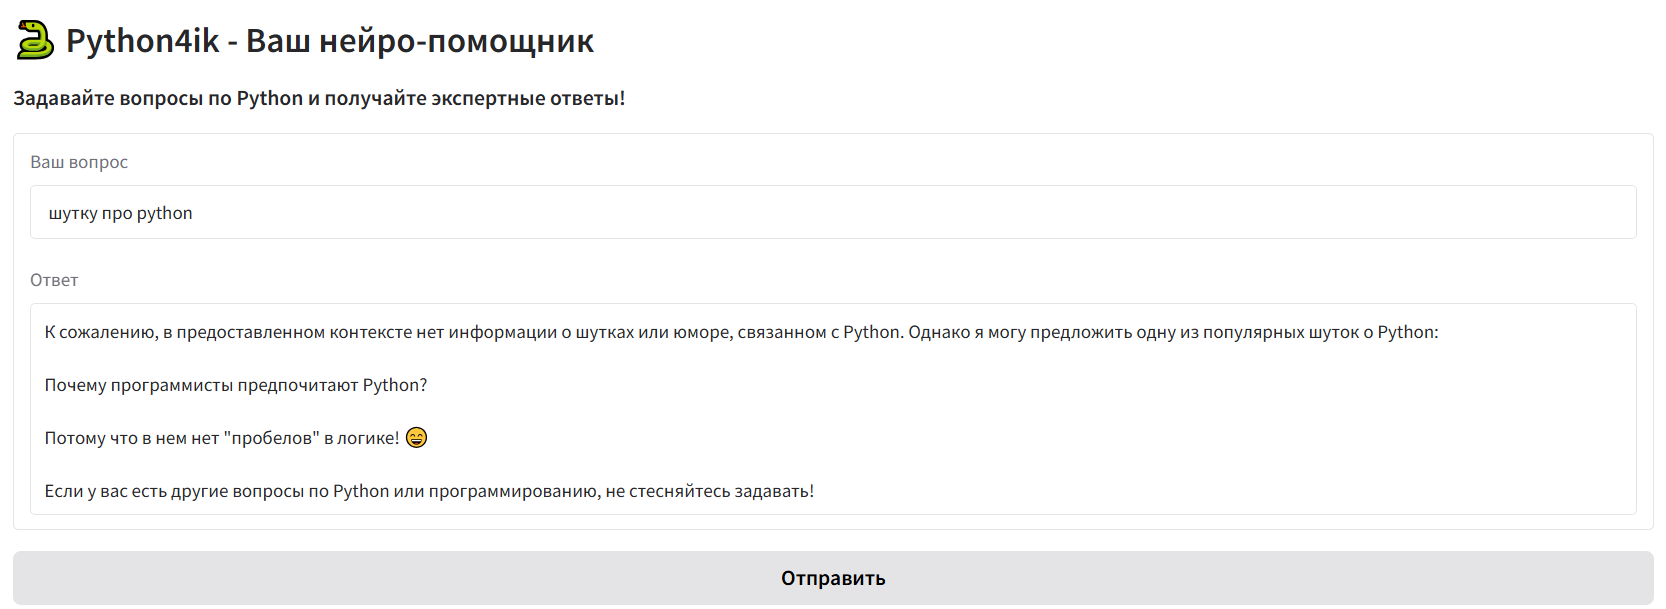

### Выводы по проведенному исследованию

1. **Эффективность структурированной базы знаний**  
   Двухуровневая организация базы знаний (темы и подтемы) значительно улучшает качество ответов нейро-сотрудника. Это позволяет модели точнее находить релевантные фрагменты и предоставлять более конкретные и полезные ответы. Например, вопросы о lambda-функциях или списочных comprehension обрабатываются корректно благодаря чёткому разделению на темы.

2. **Роль промпт-инжиниринга**  
   Чёткие инструкции в системном промпте (например, требования к тону, формату ответов и использованию примеров кода) повышают качество взаимодействия с пользователем. Это особенно важно для целевой аудитории (начинающие и средние разработчики), так как ответы становятся более понятными и структурированными.

3. **Оптимизация параметров модели**  
   Установка температуры на уровне 0.3 обеспечивает баланс между креативностью и точностью ответов. Это подтверждается примерами из исследования, где модель давала информативные ответы без избыточной генерации ненужной информации.

4. **Значение интерфейса и логирования**  
   Использование Gradio создаёт удобный и доступный веб-интерфейс для пользователей. Логирование вопросов и ответов позволяет анализировать работу системы и выявлять возможные улучшения, такие как расширение базы знаний или уточнение промптов.

5. **Обработка ошибок и кастомизация**  
   Грамотная обработка ошибок (например, сообщение об отсутствии информации в контексте) улучшает пользовательский опыт. Кастомные эмбеддинги для VSEGPT API демонстрируют гибкость системы и её способность адаптироваться к различным инструментам.

6. **Примеры успешных ответов**  
   - Вопрос о lambda-функциях получил точный ответ с синтаксисом и примером использования.  
   - Вопрос о списочных comprehension был обработан, несмотря на отсутствие прямого упоминания в контексте, что показывает способность модели обобщать знания.  
   - Запрос на шутку о Python был выполнен в дружелюбном тоне, что соответствует заданному промпту.

7. **Идеи для дальнейшего улучшения**  
   - Расширить базу знаний, добавив больше примеров и практических кейсов.  
   - Реализовать механизм обратной связи от пользователей для оценки качества ответов.  
   - Добавить поддержку обработки кода (например, выполнение простых скриптов) для более интерактивного взаимодействия.



 Нейро-сотрудник Python4ik успешно решает поставленные задачи, предоставляя точные и полезные ответы по Python. Оптимизации в структуре базы знаний, промпт-инжиниринге и интерфейсе делают его эффективным инструментом для обучения и поддержки разработчиков.